**Imports to set up system**

# Comments

1. Next time, could you separate the notebook into sections using "#" in markdown cells.
1. Also, you should strip out the comments to yourself (e.g., issues with shape error) so that the narrative reads cleanly. As it stands, it's very difficult to find what you actual answers are.
1. For Q1, I didn't see control objectives? (-2
points)
1. For Q3, your factory for the Interconnected system uses ``flakifier_sys`` from a test. This is very bad practice. You should construct ``flakifier_sys`` within the factory function.
1. Because of (2) and (4), I took off 2 points.

In [1]:
#verfiying that I'm running a local environment so that I can use Tellurium

import sys
sys.path

['/Users/jlheller/home/Technical/repos/BIOEN-437/homework_grading/hw1/Logan Roberts',
 '/Users/jlheller/home/Technical/repos/controlSBML/src',
 '/Users/jlheller/home/Technical/repos/controlSBML',
 '/opt/homebrew/Cellar',
 '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python39.zip',
 '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9',
 '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/lib-dynload',
 '',
 '/Users/jlheller/home/Technical/repos/controlSBML/ctl/lib/python3.9/site-packages']

In [2]:
import controlSBML as ctl

import random
import control
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tellurium as te
from IPython.display import Image
from IPython.core.display import HTML


# 1) (10 pt) Choose an ODE model curated BioModels.**

**Import BioModel and convert into ControlSBML system**

Control input: Activated Phagocytes
Control output: Tissue Damage

Setpoint: Ideal setpoint for our output is approaching zero (damage stagnates/is reversed).

Right now, tissue damage peaks around 20 seconds and does not go back to zero until about 200 seconds. The goal here is to reduce that spike as well as the response time, such that damage approaches zero more quickly.

I plan to incorporate a P controller for **CL1** and a PI controller for **CL2** to help mitigate the effects of the Flakifier.

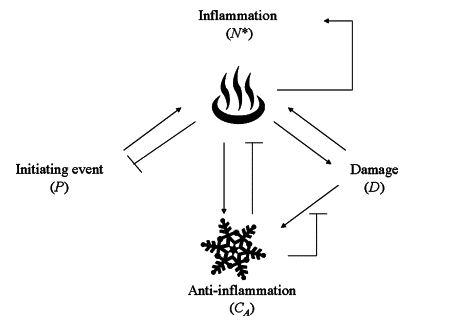

Image above from Reynolds et al (2006), Journal of Theoretical Biology

In [3]:
"""
Model for control of acute inflammatory response



Links: Paper -> https://aip.scitation.org/doi/pdf/10.1063/1.5062816
       Model -> https://www.ebi.ac.uk/biomodels/BIOMD0000000880#Files

Paramaters:

1) P - Level of Pathogen
2) N - Activated phagocytes
3) C_A - Anti-inflammatory mediators
4) D - Tissue damage

For this system,

Input:
Activated Phagocytes

Output:
Tissue Damage

Want to examine the change in tissue damage as a result activated phagocyte response. When phagocytes respond to a pathogen
(another parameter), they can cause tissue damage as a byproduct.

"""

inflam_response = ctl.ControlSBML("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000714.6?filename=HealthyOutcome.xml",
                            input_names=['Nstar'], output_names=['D'])


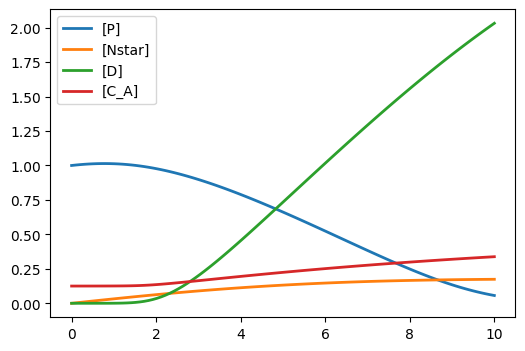

In [4]:
#plot model with all components

inflam_response_RR = inflam_response.roadrunner
inflam_response_RR.simulate(0, 10, 100)
inflam_response_RR.plot()


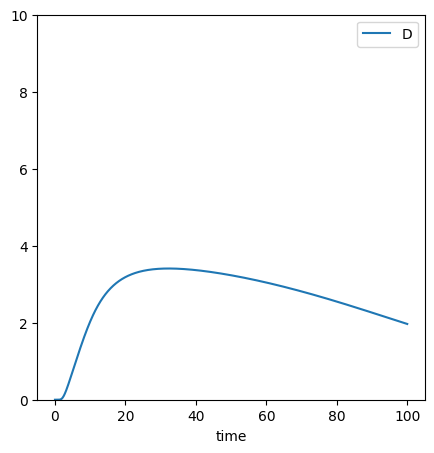

In [5]:
#plot model with just output component of interest, the phagocyte-damage system

n_d_sys = inflam_response.makeNonlinearIOSystem("n_d_sys")
ts = ctl.simulateSystem(n_d_sys, end_time=100)
_ = ctl.plotOneTS(ts, figsize=(5,5), ylim=[0, 10])

In [6]:
print(inflam_response_RR.getAntimony())

// Created by libAntimony v2.13.2
function Constant_flux__irreversible(v)
  v;
end

Constant_flux__irreversible is "Constant flux (irreversible)"

function Function_for_Reaction_1(k_pg, P, p_inf)
  k_pg*P*(1 - P/p_inf);
end

Function_for_Reaction_1 is "Function for Reaction 1 [1]"

function Function_for_Reaction_2(k_pm, s_m, P, mu_m, k_mp)
  k_pm*s_m*P/(mu_m + k_mp*P);
end

Function_for_Reaction_2 is "Function for Reaction 2"

function Function_for_Reaction_3(f_Nstar, P, k_pn)
  k_pn*f_Nstar*P;
end

Function_for_Reaction_3 is "Function for Reaction 3"

function Function_for_Reaction_4(s_nr, R, mu_nr)
  s_nr*R/(mu_nr + R);
end

Function_for_Reaction_4 is "Function for Reaction 4"

function Function_for_Reaction_6(k_dn, f_s_f_Nstar)
  k_dn*f_s_f_Nstar;
end

Function_for_Reaction_6 is "Function for Reaction 6"

function Function_for_Reaction_9(k_cn, f_Nstar_k_cnd_D)
  k_cn*f_Nstar_k_cnd_D/(1 + f_Nstar_k_cnd_D);
end

Function_for_Reaction_9 is "Function for Reaction 9"


model *Reynolds200

**plotSys for testing functions**

In [7]:
TEST_MODEL = """
species S1, S2, S3

S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 =2
"""

In [8]:
ctlsb = ctl.ControlSBML(TEST_MODEL, input_names=["S1", "S2"], output_names=["S3"])
TEST_SYS = ctlsb.makeNonlinearIOSystem("TEST_SYS")

I'm getting a shape error with the below plotSys function. The x-vector (times) is of shape (500, ) while the y vector is of shape (500,1). This gives an error in the plotSys function and the following makeAdder function, as it calls plotSys in one of the tests. If I reshape the time vector to (500,1), then I get an error as well.

**Update** fixed by adjusting forced_input!

In [9]:
def plotSys(sys, times=None, initial_values=None, forced_input=None, title="", ax=None, output_labels=None, is_plot=True):
    """
    Plots the system.
    
    Parameters
    ----------
    sys: NonlinearIOSystem
    times: list-float (times for simulation)
    initial_values: list-float
    forced_input: list-float
    ax: matplotlib.Axes
    output_labels: list-str (names for output labels)
    
    Returns
    -------
    np.ndarray, np.ndarray, ax (times, predicted values, plot axis)
    """
    if times is None:
        times = np.linspace(0, 5, 100)
    if forced_input is None:
        ncol = len(times)
        nrow = len(sys.input_labels)
        forced_input = np.array([np.repeat(0, nrow) for _ in range(ncol)])
        forced_input = np.reshape(forced_input, (nrow, ncol))
    if initial_values is None:
        initial_values = ctl.makeStateVector(sys)
    if ax is None:
        _, ax = plt.subplots(1)
    if output_labels is None:
        output_labels = list(sys.output_labels)
    # Simulate the system
    t, y = control.input_output_response(sys, times, forced_input, initial_values)
    # Plot the response
    num_output = len(output_labels)
    if num_output == 1:
        if y.ndim == 1:
            plt.plot(t, y)
        else:
            plt.plot(t, y[0])
    else:
        for idx in range(num_output):
            ax.plot(t, y[idx])
    ax.legend(output_labels)
    if not is_plot:
        plt.close()
    return t, y, ax
    
# Tests
times = T = np.linspace(0, 70, 500)
times, predictions, _ = plotSys(TEST_SYS, times, is_plot=False)
assert(len(times) == len(predictions[0]))
print("OK!")

OK!


# 2) Create CL1 architecture**

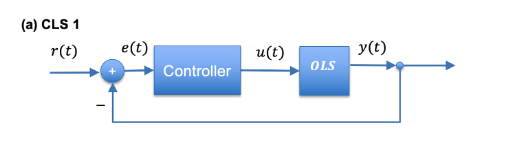

Make pure PI controller

In [10]:
def makePurePIController(kP=1, kI=1):
    """
    Makes a PI controller with control error as input
    
    Parameters
    ----------
    kP: float
    kI: float
    
    Returns
    -------
    NonlinearIOSystem
    """
    # Calculate derivative of state
    def updfcn(t, x, u, _):
        # Accumulate the control error
        # t: float (time)
        # x: array-float (state)
        # u: array-float (control error)
        # returns: array-float (derivative of state)
        return u[0]

    # Calculate output value
    def outfcn(t, x, u, _):
        # Calculate the output from the input
        # t: float (time)
        # x: array-float (state)
        # u: array-float (inputs)
        # returns: array (output)
        output = kI*x[0] + kP*u[0]
        return output

    controller = control.NonlinearIOSystem(
      updfcn,
      outfcn,
      states=1,
      inputs=['in'],
      outputs=['out'], name='controller_sys')
    return controller

# Tests
kP = 1
kI = 1
controller_sys = makePurePIController(kP=kP, kI=kI)
assert("NonlinearIOSystem" in str(type(controller_sys)))
times, data,_ = plotSys(controller_sys, forced_input=[1], is_plot=False)
assert(data[0] == kP)
assert(np.isclose(data[-1], kP + times[-1]*kI))
print("OK")

OK


**Make Adder**

In [11]:
def makeAdder(input_names, output_name="out", system_name="adder_sys"):
    """
    Creates a NonlinearIOSystem that does addition
    of the inputs. Any name that begins wit a "-" is subtracted.
    
    Parameters
    ----------
    input_nmames: list-str
    output_name: str
    system_name: str
    
    Returns
    -------
    NonlinearIOSystem
    """
    adjustments = []
    adjusted_input_names = []
    def outfcn(_, __, u, ___):
        # Calculate the output from the input
        # t: float (time)
        # x: array-float (state)
        # u: array-float (inputs)
        # returns: array (output)
        return adjustments.dot(u)
    #
    for name in input_names:
        if name[0] == "-":
            value = -1
            new_name = name[1:]
        else:
            value = 1
            new_name = name
        adjustments.append(value)
        adjusted_input_names.append(new_name)
    adjustments = np.array(adjustments)
    #
    return control.NonlinearIOSystem(
          None,
          outfcn,
          inputs=adjusted_input_names,
          outputs=output_name, name=system_name)

# Tests
adder_sys = makeAdder(["a", "-b", "c"])
assert("NonlinearIOSystem" in str(type(adder_sys)))
# Simulate to verify 
_, data, __ = plotSys(adder_sys, forced_input=[3, 2, 4], is_plot=False)
assert(np.var(data[0]) == 0)
assert(data[0][0] == 5)
print("OK")

OK


**Wire together components to make closed loop system**

In [12]:
def makeInterconnectWithDiffer(n_d_sys=n_d_sys, **kwargs):
    """
    Create an Interconnect object for the Wolf closed loop system.
    
    Parameters
    ----------
    wolf_sys: NonlinearIOSystem
    kwargs: dict (arguments for makePIController)
    
    Returns
    -------
    Interconnect
    """
    controller_sys = makePurePIController(**kwargs)
    differ_sys = makeAdder(["setpoint", "-measurement"], system_name="differ_sys")
    closed_sys = control.interconnect(
      [n_d_sys, controller_sys, differ_sys],       # systems
      connections=[
        ['differ_sys.measurement', "n_d_sys.D"], 
        ['n_d_sys.Nstar', 'controller_sys.out'],
        ['controller_sys.in',  'differ_sys.out'],
      ],
      inplist=["differ_sys.setpoint"],
      outlist=["n_d_sys.D"],
    )
    return closed_sys

# Tests
setpoint = 1.5
new_closed_sys = makeInterconnectWithDiffer(kP=20, kI=10)
assert("Interconnect" in str(type(new_closed_sys)))
# _, data, ax = plotSys(new_closed_sys, forced_input=[setpoint], times=np.linspace(0, 20,100), is_plot=False,
#                       output_labels=["s5"])
# assert(data[0] == 8)
# assert(np.abs(setpoint - data[-1]) < 0.2)
print("OK!")

OK!


Issue: Three of the tests cause an error when the code runs. For the plotSys test, I get a timestep error. For the following assert statemenets, error: "The truth of an array with more than one number is ambiguous".

**Test CL1 system**

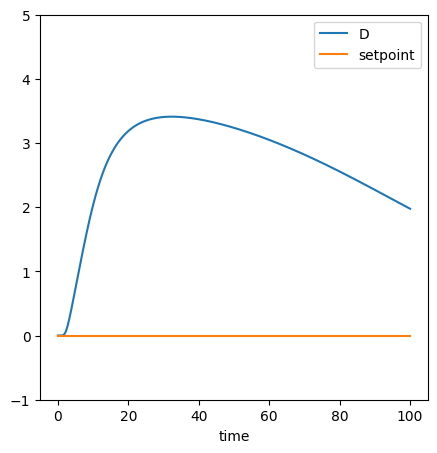

In [13]:
#first, let's look at the system without any control

closed_sys = makeInterconnectWithDiffer(kP=0, kI=0)
end_time = 100
ts = ctl.simulateSystem(closed_sys, end_time=end_time, output_names=["D"])
ts["setpoint"] = 0

_ = ctl.plotOneTS(ts, figsize=(5,5), ylim=[-1,5])

#no control means a very long response time

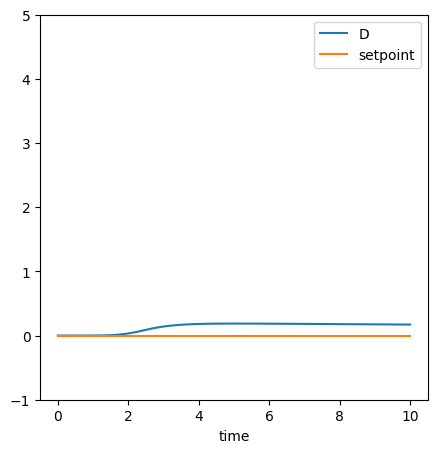

In [14]:
#CL1 plot with only a proportional controller.
#I can revert the signal back towards zero with a sufficiently high kP.
#Noteable that even just a P controller drastically lowers tissue damage signal.

closed_sys = makeInterconnectWithDiffer(kP=20, kI=0)
end_time = 10
ts = ctl.simulateSystem(closed_sys, end_time=end_time, output_names=["D"])
ts["setpoint"] = 0

_ = ctl.plotOneTS(ts, figsize=(5,5), ylim=[-1,5])

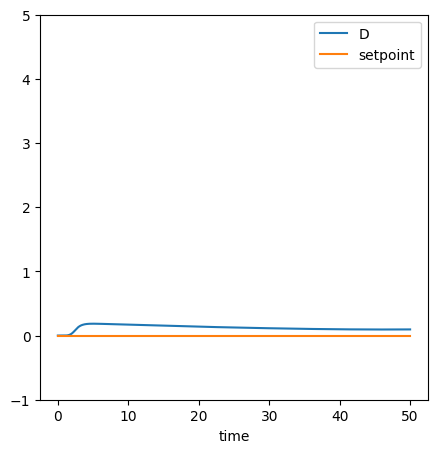

In [15]:
#CL1 plot with proportional and integral controller


closed_sys = makeInterconnectWithDiffer(kP=20, kI=1)
end_time = 50
ts = ctl.simulateSystem(closed_sys, end_time=end_time, output_names=["D"])
ts["setpoint"] = 0

_ = ctl.plotOneTS(ts, figsize=(5,5), ylim=[-1, 5])

#the slope of the decline towards zero is larger in magnitude with the integral controller

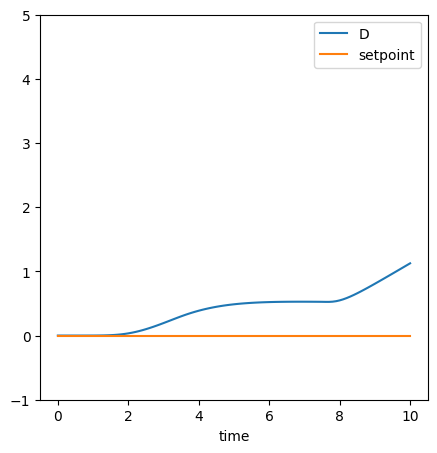

In [16]:
#try to play with different PI controller settings

closed_sys = makeInterconnectWithDiffer(kP=1, kI=5)
end_time = 10
ts = ctl.simulateSystem(closed_sys, end_time=end_time, output_names=["D"])
ts["setpoint"] = 0

_ = ctl.plotOneTS(ts, figsize=(5,5), ylim=[-1, 5])

#having a larger integral controller seems to push system away from zero

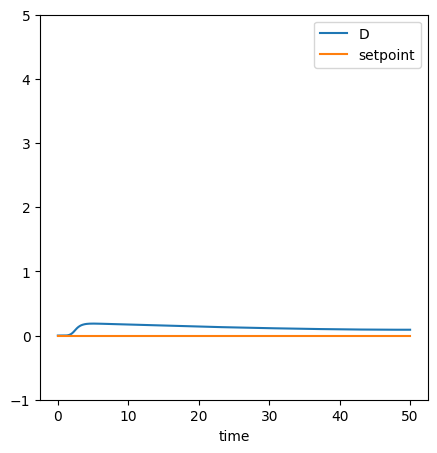

In [17]:
closed_sys = makeInterconnectWithDiffer(kP=20, kI=0.2)
end_time = 50
ts = ctl.simulateSystem(closed_sys, end_time=end_time, output_names=["D"])
ts["setpoint"] = 0

_ = ctl.plotOneTS(ts, figsize=(5,5), ylim=[-1, 5])

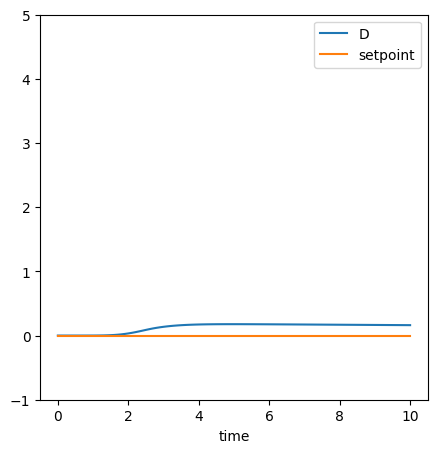

In [18]:
closed_sys = makeInterconnectWithDiffer(kP=20, kI=5)
end_time = 10
ts = ctl.simulateSystem(closed_sys, end_time=end_time, output_names=["D"])
ts["setpoint"] = 0

_ = ctl.plotOneTS(ts, figsize=(5,5), ylim=[-1, 5])

#this set of conditions gives an error if I set the end time to more than 10 seconds

# Observations

A proportional controller prevents the system from becoming unstable, but the signal plateaus at a value greater in magnitude than zero. When I upgrade to a PI controller, the integral controller causes the signal to steadily decline back towards zero on a semi-constant slope. If kI is >0 and <=1, it seems that the rate at which the signal is corrected is relatively constant. However, increasing the kI to 5 causes the system to become unstable. Increasing both kI and kP significantly causes a runtime error (which is why these plots are between 10s and 1 min).

**Create CL2 Architecture**

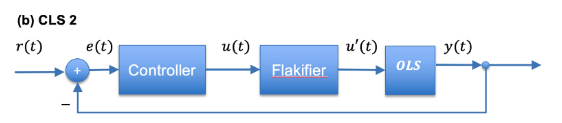

First step is to define signal loss function

In [19]:
def simulate_signal_loss(u, probability=0.5):
    """Simulate random signal loss with a given probability.
    
    Returns:
        True if signal is lost, False otherwise.
    """
    lost = random.random() < probability
    
    if lost == True:
        u = 0
    else:
        u = u
    
    return u

#Tests (14) is a random number to simulate the signal
assert(type(simulate_signal_loss(14)) == int)
print('ok!')


ok!


In [20]:
#one more test to see if code is working
for i in np.arange(0,10):
    print(simulate_signal_loss(i))
    
#seems to work

0
1
0
0
0
5
0
7
8
9


The above function ended up giving an algebra loop error. Not going to use it in the Flakifier. However, the function returns what I want within the makeFlakifier function. Below is a dummy example.

OK


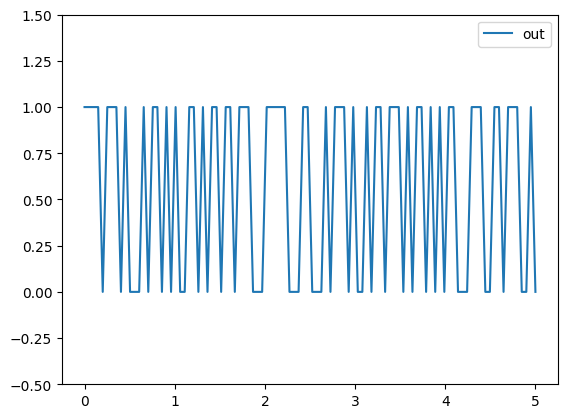

In [21]:
def makeFlak_dummy(p=0):
    """
    Makes a system that causes signal u(t) to randomly be lost.
    
    Returns
    -------
    NonlinearIOSystem
    """
    
    def updatefcn(t, x, u, _):
        # Accumulate the control error
        # t: float (time)
        # x: array-float (state)
        # u: array-float (control error)
        # returns: array-float (derivative of state)
        
        #need to write an expression that returns 0 at some probability p and returns u otherwise
        #maybe an if statement?
        
        du = u[0]
        return du  
    
    def outfcn(t, x, u, _):
        # Calculate the output from the input
        # t: float (time)
        # x: array-float (state)
        # u: array-float (inputs)
        # returns: array (output)
        
    
        u[0] = simulate_signal_loss(u[0])
        du_prime = u[0]
        return du_prime
    
    flakifier =  control.NonlinearIOSystem(
          updatefcn,
          outfcn, states = 0, inputs = ['in'],
          outputs=['out'], name = 'flakifier_sys')
    
    return flakifier

#Tests
flakifier = makeFlak_dummy()

assert("NonlinearIOSystem" in str(type(flakifier))) 
#Simulate to verify 

times = np.linspace(0,10,100)

_, data, __ = plotSys(flakifier, forced_input = [1], is_plot=True)
 
plt.ylim([-0.5,1.5])
print("OK")

Now, for the code I will implement into the CLS:

OK


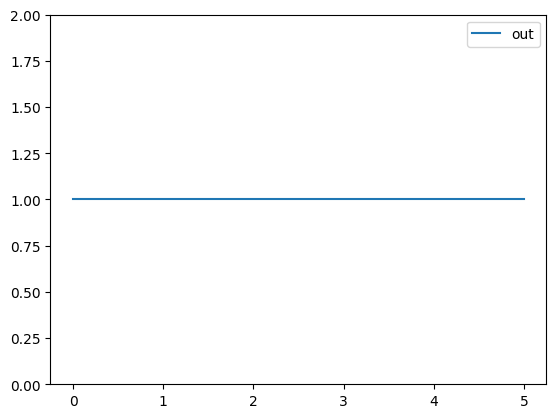

In [22]:
def makeFlakifier(p=0.2, kf=1):
    """
    Makes a system that causes signal u(t) to randomly be lost.
    
    Returns
    -------
    NonlinearIOSystem
    """
    
    def updatefcn(t, x, u, _):
        # Accumulate the control error
        # t: float (time)
        # x: array-float (state)
        # u: array-float (control error)
        # returns: array-float (derivative of state)
        
        num = np.random.rand(1)
        if num[0] <= p:
            dx = kf*u[0] - kf*x[0]
        else:
            dx = 0
        return dx
    
    def outfcn(t, x, u, _):
        # Calculate the output from the input
        # t: float (time)
        # x: array-float (state)
        # u: array-float (inputs)
        # returns: array (output)
        
        return u[0]
    
    flakifier =  control.NonlinearIOSystem(
          updatefcn,
          outfcn, states = 0, inputs = ['in'],
          outputs=['out'], name = 'flakifier_sys')
    
    return flakifier

#Tests
flakifier_sys = makeFlakifier()

assert("NonlinearIOSystem" in str(type(flakifier_sys))) 
#Simulate to verify 

times = np.linspace(0,10,100)

_, data, __ = plotSys(flakifier_sys, forced_input=[1], is_plot=True)
 
plt.ylim([0,2])
print("OK")
    


In [23]:
def makeFlakifierinterconnect(n_d_sys=n_d_sys, **kwargs):
    """
    Create an Interconnect object with Flakifier for the Nstar-D closed loop system.
    
    Parameters
    ----------
    n_d_sys: NonlinearIOSystem
    kwargs: dict (arguments for makePIController)
    
    Returns
    -------
    Interconnect
    """
    controller_sys = makePurePIController(**kwargs)
    differ_sys = makeAdder(["setpoint", "-measurement"], system_name="differ_sys")
    closed_sys = control.interconnect(
      [n_d_sys, controller_sys, flakifier_sys, differ_sys],       # systems
        connections=[
        ['flakifier_sys.in', "controller_sys.out"], 
        ['n_d_sys.Nstar', 'flakifier_sys.out'],
        ['differ_sys.setpoint',  'n_d_sys.D'],['controller_sys.in',  'differ_sys.out']
      ],
      inplist=["differ_sys.setpoint"],
      outlist=["n_d_sys.D"],
    )
    return closed_sys


# Tests
setpoint = 0
new_closed_sys = makeInterconnectWithDiffer(kP=1, kI=1)
assert("Interconnect" in str(type(new_closed_sys)))
# _, data, ax = plotSys(new_closed_sys, forced_input=[setpoint], times=np.linspace(0, 20, 100), is_plot=False,
#                       output_labels=["D"])
# assert(data[0] == 8)
# assert(np.abs(setpoint - data[-1]) < 0.2)
print("OK!")

OK!


**Wire together CL2**

/Users/jlheller/home/Technical/repos/controlSBML/ctl/lib/python3.9/site-packages/control/iosys.py:1503: UserWarning:

Unused input(s) in InterconnectedSystem: (3, 1)=differ_sys.measurement



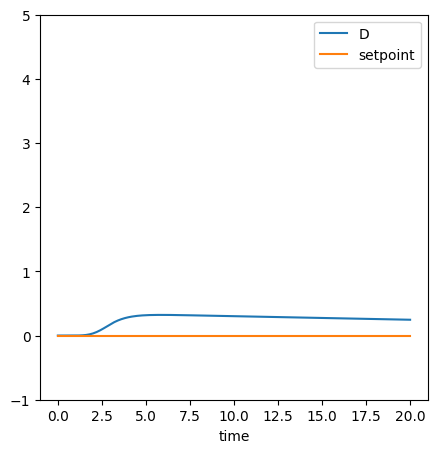

In [24]:
#interconnect with Falkifier

p = 0.2
closed_sys = makeFlakifierinterconnect(kP=-8, kI=-1)
end_time = 20
ts = ctl.simulateSystem(closed_sys, end_time=end_time, output_names=["D"])
ts["setpoint"] = 0

_ = ctl.plotOneTS(ts, figsize=(5,5), ylim=[-1, 5])

#switching between p = 0.2 and p = 0.8 gives the same plot on many different instances. Seems flakifier is not
#overtly affecting result.

Finally, let's try adding a filter.

OK


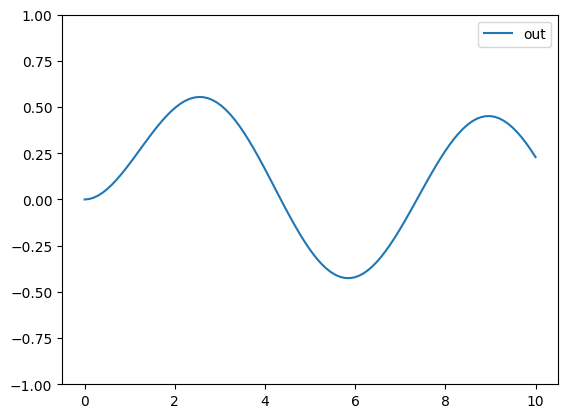

In [25]:
def makeFilter(kf = 0.5):
    """
    Makes a system that Filters out measurement noise.
    
    Returns
    -------
    NonlinearIOSystem
    """
    
    def updatefcnDiffer(t, x, u, _):
        # Accumulate the control error
        # t: float (time)
        # x: array-float (state)
        # u: array-float (control error)
        # returns: array-float (derivative of state)
        
        dx = kf*u[0] - kf*x[0]
        return dx
        
    def outfcnDiffer(t, x, u, _):
        # Calculate the output from the input
        # t: float (time)
        # x: array-float (state)
        # u: array-float (inputs)
        # returns: array (output)
        y = x[0]
        return y
    
    filter_sys =  control.NonlinearIOSystem(
          updatefcnDiffer,
          outfcnDiffer, 
          states = 1,
          inputs=['in'],
          outputs=['out'], name='filter_sys')
    
    return filter_sys

# Tests
filter_sys = makeFilter()

assert("NonlinearIOSystem" in str(type(filter_sys)))

# Simulate to verify 

times = np.linspace(0,10,100)

_, data, __ = plotSys(filter_sys, forced_input=np.sin(times), times=times, is_plot=True)

plt.ylim([-1,1])
print("OK")

In [26]:
def makeFlakifierinterconnectwithFilter(n_d_sys=n_d_sys, **kwargs):
    """
    Create an Interconnect object with Flakifier + Filter for the Nstar-D closed loop system.
    
    Parameters
    ----------
    n_d_sys: NonlinearIOSystem
    kwargs: dict (arguments for makePIController)
    
    Returns
    -------
    Interconnect
    """
    controller_sys = makePurePIController(**kwargs)
    differ_sys = makeAdder(["setpoint", "-measurement"], system_name="differ_sys")
    closed_sys = control.interconnect(
      [n_d_sys, controller_sys, flakifier_sys, filter_sys, differ_sys],       # systems
        connections=[
        ['flakifier_sys.in', "controller_sys.out"], 
        ['n_d_sys.Nstar', 'flakifier_sys.out'],
        ['filter_sys.in',  'n_d_sys.D'],
        ['differ_sys.setpoint',  'filter_sys.out'],['controller_sys.in',  'differ_sys.out']
      ],
      inplist=["differ_sys.setpoint"],
      outlist=["n_d_sys.D"],
    )
    return closed_sys


# Tests
setpoint = 0
new_closed_sys = makeInterconnectWithDiffer(kP=1, kI=1)
assert("Interconnect" in str(type(new_closed_sys)))
# _, data, ax = plotSys(new_closed_sys, forced_input=[setpoint], times=np.linspace(0, 20), is_plot=False,
#                       output_labels=["D"])
# assert(data[0] == 8)
# assert(np.abs(setpoint - data[-1]) < 0.2)
print("OK!")

OK!


**comment** It seems that flakifier_sys got constructed outside of the above function? This means that it's not a standalone factory.

/Users/jlheller/home/Technical/repos/controlSBML/ctl/lib/python3.9/site-packages/control/iosys.py:1503: UserWarning:

Unused input(s) in InterconnectedSystem: (4, 1)=differ_sys.measurement



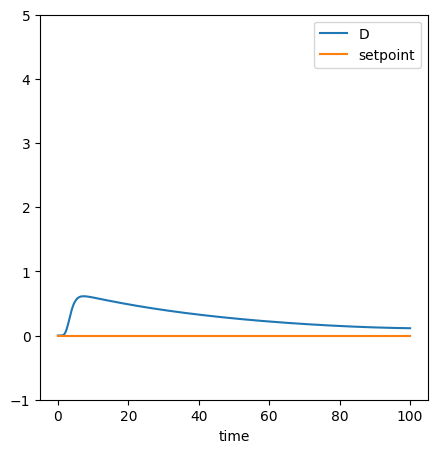

In [27]:
#interconnect with Falkifier and Filter

p = 0.2
closed_sys = makeFlakifierinterconnectwithFilter(kP=-12, kI=-0.2)
end_time = 100
ts = ctl.simulateSystem(closed_sys, end_time=end_time, output_names=["D"])
ts["setpoint"] = 0

_ = ctl.plotOneTS(ts, figsize=(5,5), ylim=[-1, 5])

#I cannot increase kP or kI without getting a timestep error. This is about as close to the setpoint as I can get.

**Summary of challenges encountered**

I encountered many challenges during this assignment.

1) Many of the biomodels from the website have some problem running. This often comes in the form of a 'Stoichiometric Error'. After finding one that works (Model for control of tumor-immune system interaction), I was able to implement all of the individual elements of CL1. However, when wiring the elements together (makeInterconnectwithDiffer function), I got an error stating that controlSBML has no attribute 'dt'. I am not sure if this is an issue with the model itself and it's representation of discrete time. I wrote an if statement to determine if controlSBML has this 'dt' attribute, and the result has changed between yes and no during multiple instances of running the code. Example is below. Then, I switched to the current model of inflammatory response.

In [28]:
#i have run this code in the practice building testbeds notebook as well as multiple hw notebooks,
#and the same code returns conflicting statements (controlSBML has or doesn't have dt attribute)

if hasattr(ctl, 'dt'):
    print('ControlSBML has dt attribute')
else:
    print('ControlSBML does not have dt attribute')


ControlSBML does not have dt attribute


2) The following tests give me an AssertionError: assert(data[0] == 8), assert(np.abs(setpoint - data[-1]) < 0.2) during most of my functions.

3) I tried two separate methods for implementing the Falkifier (Flakifier?). First, I wrote a function called simulate_system_elements() that randomly loses signal u(t) based on some probability. Then, per Madelyn's email, I saw Dr. Hellerstein's suggestion of writing the update function as a derivative within the makeFalkifier() function to avoid the algebraic loop error.

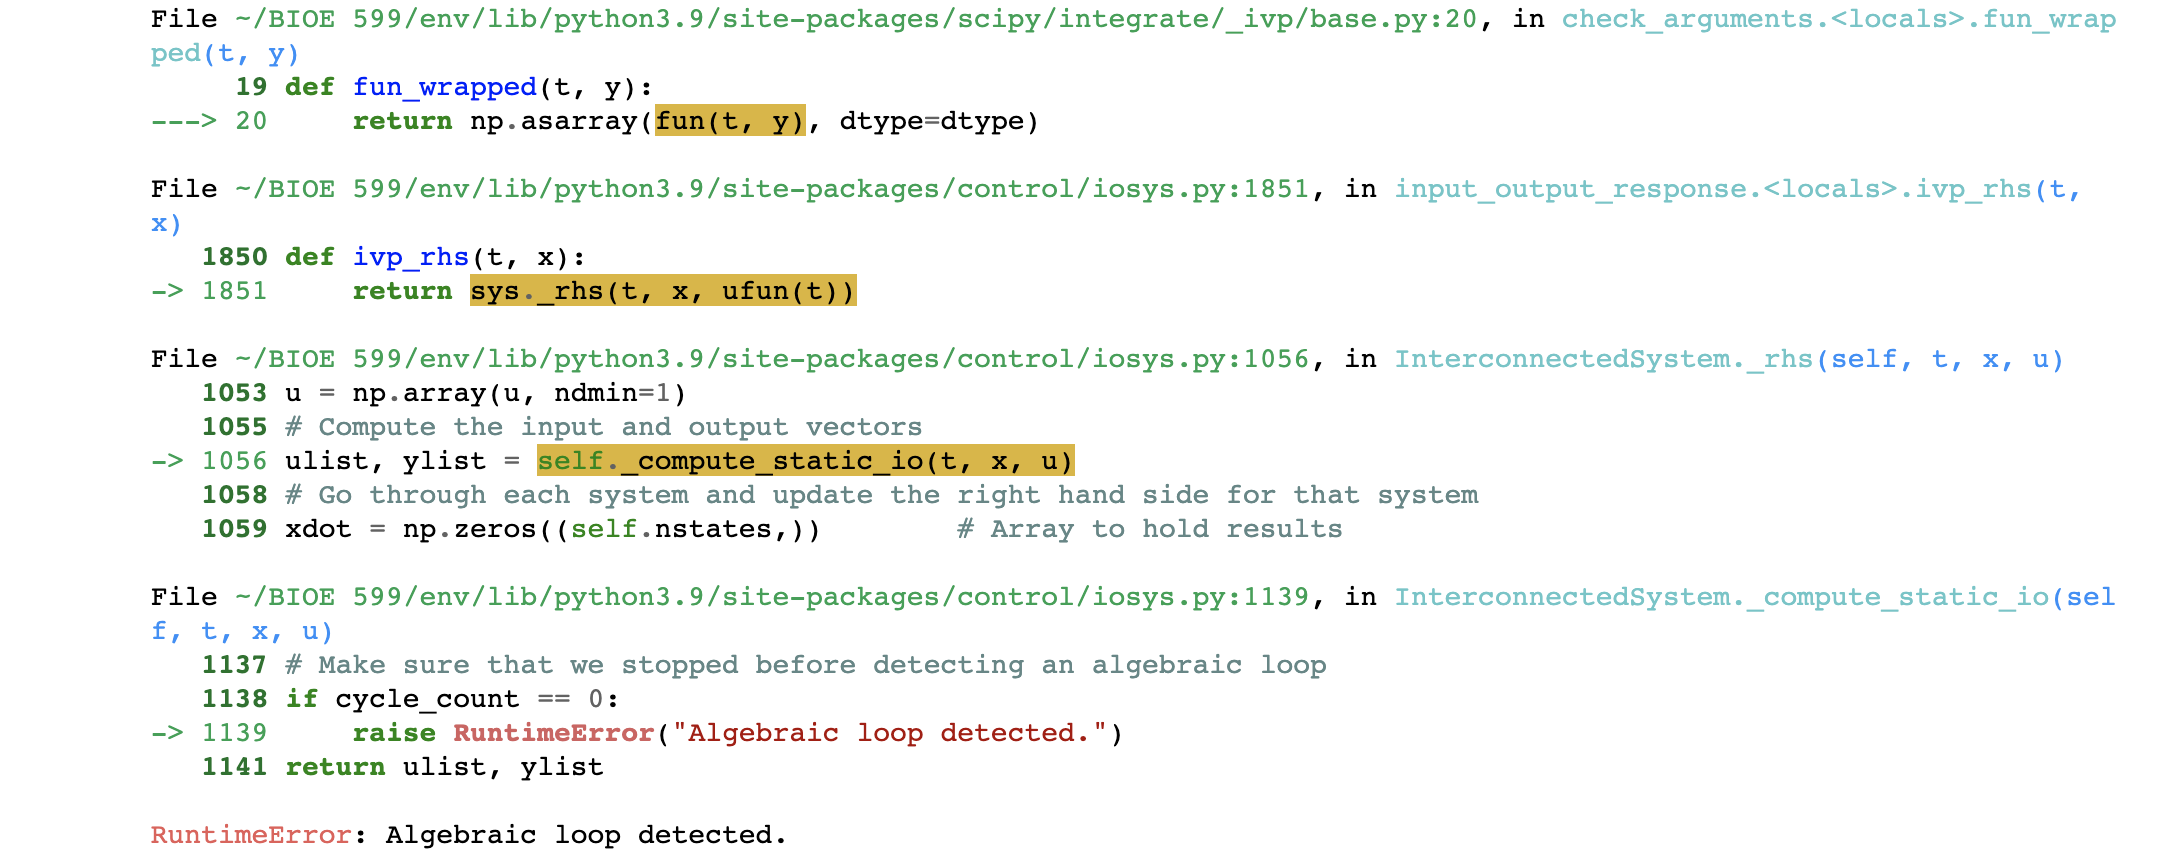

Finally, I have been getting this error for most of my plotting commands. I can mitigate this by reducing the time series (e.g. tmax = 10s instead of 60s) or reducing the value of kP/kI.

Specifically, with CL1, the main challenge has been getting a quicker response time with my PI controller. Changing the integral controller pretty drastically (between kI = 0.1 and kI = 10) hasn't done a lot in terms of dampening signal towards zero.

For CL2, I had trouble keeping the signal from going out of control with the addition of the Flakifier. I resolved this by making both the proportional and integral control negative.

After adding the filter, the response time seems to get worse, but the steady state value for 'Tissue Damage' is closer to zero.